# Enunciado del ejercicio

Queremos seleccionar el conjunto de datos de los pingüinos y probar a realizar unos modelos de aprendizaje automático supervisado de regresión y otro de clasificación. Para ello, vamos a tomar como **X** el df SIN el peso y SIN la isla. 

1. Para regresión, tomaremos como **Y** el peso. 

2. Para clasificación, tomaremos como **Y** la isla. 

En cualquier caso, codearemos las variables *no numéricas* de **X** e **Y** (con label enconder, por ejemplo, por agilidad) y normalizaremos todas las variables de **X**. 

Comprobaremos el error cometido y lo compararemos con otro modelo del mismo tipo. 

También haremos una pequeña prueba e intentaremos implementar un modelo no supervisado, usando kmeans: ¿qué 3 grupos se formaría si solo atendemos a la longitud y anchura del pico? 

# Esquema General

Al trabajar con modelos conocidos, lo más probable es que ya existan librerías que implementen modelos completamente elaborados mediante poco código. Por lo tanto, es importante hacer una investigación inicial de la literatura para verificar si ya existe alguna librería que nos facilite la parte puramente matemática y de creación del modelo del ejercicio, por lo que ganaremos en productividad y nos podremos centrar más en la parte comparativa de los modelos que en el diseño del mismo.

Dicho lo anterior, lo más común es que nuestro trabajo al implementar modelos de ML siga los siguientes pasos:<br>
```python
#Importamos el modelo deseado de la librería que hayamos encontrado
from AlgúnSitio import Modelo_Chulo
#Instanciamos al modelo y le introducimos los parámetros deseados
modelo = Modelo_Chulo(hiperparámetros)
#Entrenamos al modelo con nuestra muestra, partiéndola en entrenamiento y test previamente
modelo.fit(X_train, y_train) # aquí es donde tarda
#Realizamos las predicciones
y_pred = modelo.predict(X_test)
#Comprobamos errores
revisar_errores(y_test,y_pred)
```

# Importamos librerías y leemos datos

Vamos a importar las librerías principales aquí, y las necesarias en cada modelo para separar cuál usar en cada caso. De todas formas, adelanto que todos los modelos provienen de sklearn, por lo que los traeremos con un from.

In [ ]:
%pip install -q -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
penguins = sns.load_dataset("penguins")
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
penguins.shape

(344, 7)

In [4]:
penguins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [5]:
penguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [6]:
penguins.dropna(inplace=True) # vamos a dropear los nulos directamente
penguins.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [7]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1) # definimos las variables explicativas como el df sin las columnas indicadas
X.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,Adelie,39.1,18.7,181.0,Male
1,Adelie,39.5,17.4,186.0,Female
2,Adelie,40.3,18.0,195.0,Female
4,Adelie,36.7,19.3,193.0,Female
5,Adelie,39.3,20.6,190.0,Male


In [8]:
X.shape

(333, 5)

Como se puede ver, el número de filas se ha reducido en 11 por la eliminación de nulos (el mayor número de nulos estaban en la columna sex y eran 11), y el número de columnas se ha reducido en 2 por la eliminación de dos columnas

# Regresión: `y=penguins["body_mass_g"]`

## Preparación de datos

Queremos que nuestra variable objetivo, **y**, sea el peso de los pingüinos, y vamos a predecirlo con las variables de **X**: Bill length, bill depth, flipper length, sex y species

In [9]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
y = penguins["body_mass_g"]

## Modelo 1. ElasticNet 

In [10]:
#Librerías
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
alpha = 0.1 #Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = 0.1 #Parámetro que mide el tradeoff entre el peso l1 y el l2

#Instanciamos el modelo
model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 42) #indicamos una semilla para reproducibilidad

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas] #Esto es un poco redundante en este caso, pero en otros ejemplos, como en KNN, sí tenemos que añadir 
# alguna otra columna, como "clasificacion[columnas + ["otra_columna"]]", o porque la copia proviene no de X sino de otro dataframe 
# con más columnas, por lo que es una buena práctica indicarlo

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if regresion[col].dtypes != "object":
        regresion[col] = scaler.fit_transform(regresion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if regresion[col].dtypes == "object":
        regresion[col] = encoder.fit_transform(regresion[col])

#Dividimos datos (al 30% por tener una muestra pequeña)
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_ElasticNet = mse(y_test, y_pred) 

# donde mse_ElasticNet = np.sum((y_test-model.predict(X_test))**2)/1000

In [11]:
regresion #Para ver cómo ha quedado el dataframe tras las transformaciones. Es una buena práctica hacerlo para ver si 
# las transformaciones se han aplicado correctamente. Por ejemplo, si se aplica primero un LabelEncoder para codear las variables
# categóricas y luego un StandardScaler para normalizar las variables numéricas, estaremos normalizando las variables que antes
# eran objects

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


In [12]:
y_pred #Para ver las predicciones del modelo para el conjunto X_test (100 predicciones en este caso, es decir, el 30% de 333)

array([3133.18729952, 4966.86111608, 3941.89009865, 3907.24247408,
       3889.04053939, 4692.85696786, 5363.0438973 , 4144.4365102 ,
       4099.74410211, 4311.70119922, 4037.58137565, 3957.44520638,
       4561.54395618, 3525.19998079, 4604.08045076, 3363.15089929,
       3395.87357724, 3698.30322644, 3325.31363913, 4749.77274296,
       4007.24245495, 3879.69150958, 5520.82471236, 4344.29705873,
       3179.32522311, 3432.72100938, 4745.8591387 , 4664.59765487,
       3345.43568705, 5511.75403895, 3603.5512648 , 5491.91353974,
       4022.61048987, 3828.79990649, 5503.57109463, 4578.62719491,
       3772.87779411, 4575.41596294, 3460.25387295, 3422.80616744,
       3115.41838231, 3458.98568854, 3920.58141394, 3963.16146908,
       3778.10804591, 3443.94759629, 5310.82040453, 3735.11479022,
       3751.75100955, 4853.89952754, 3522.55456095, 5147.3247339 ,
       4626.1096087 , 3497.69641155, 3363.20033832, 5215.69493965,
       3216.42629214, 3855.49733881, 4135.87311055, 4383.24989

In [13]:
mse_ElasticNet #Para ver el error cuadrático medio (Mean Squared Error) de las predicciones

106871.65967370642

## Modelo 2. Stochastic Gradient Descent

In [14]:
#Librerías
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
penalty = 'elasticnet' #Elegimos entre penalización 'l2', 'l1' o 'elasticnet'
alpha = .1 #Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = .1 #Parámetro que mide el tradeoff entre el peso l1 y el l2

#Instanciamos el modelo
model = SGDRegressor(penalty = penalty, alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 42)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if regresion[col].dtypes != "object":
        regresion[col] = scaler.fit_transform(regresion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if regresion[col].dtypes == "object":
        regresion[col] = encoder.fit_transform(regresion[col])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SGDRegressor = mse(y_test,model.predict(X_test))
print(mse_SGDRegressor)

106225.4071401651


In [15]:
regresion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Modelo 3. Support Vector Regression

In [16]:
#Librerías
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
C = 1 #Parámetro regularizador
kernel = 'rbf' #Núcleo transformador

#Instanciamos el modelo
model = svm.SVR(C = C, kernel = kernel)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if regresion[col].dtypes != "object":
        regresion[col] = scaler.fit_transform(regresion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if regresion[col].dtypes == "object":
        regresion[col] = encoder.fit_transform(regresion[col])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_SVR = mse(y_test,model.predict(X_test))
print(mse_SVR)

578415.2458962575


In [17]:
regresion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Modelo 4. Random Forest

In [18]:
#Librerías
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
n_estimators = 200 #Estimadores del modelo
criterion = 'squared_error' #Forma de calcular el error
max_depth = None #Límite de profundidad de los árboles
min_samples_split = 2 #Criterio de parada de profundidad
verbose = 1 #Información devuelta por el método

#Instanciamos el modelo
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if regresion[col].dtypes != "object":
        regresion[col] = scaler.fit_transform(regresion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if regresion[col].dtypes == "object":
        regresion[col] = encoder.fit_transform(regresion[col])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train, y_train)
mse_RF = mse(y_test,model.predict(X_test))
print(mse_RF)

79743.31671875


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


In [19]:
regresion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Modelo 5. Boosting: Gradient Descent

In [20]:
#Librerías
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Inicializamos modelo y parámetros
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10

#Variables dependientes
regresion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
regresion = regresion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if regresion[col].dtypes != "object":
        regresion[col] = scaler.fit_transform(regresion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if regresion[col].dtypes == "object":
        regresion[col] = encoder.fit_transform(regresion[col])

#Dividimos datos
X_train, X_test, y_train, y_test = train_test_split(regresion, y, random_state=42, test_size = .3)

#Convertimos los datos a formato DMatrix
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

#Instanciamos el modelo, entrenamos y elaboramos predicciones
model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = mse(y_test,model.predict(test_data))
print(mse_XGB)

79672.00410452187


In [21]:
regresion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Comparativa de Modelos

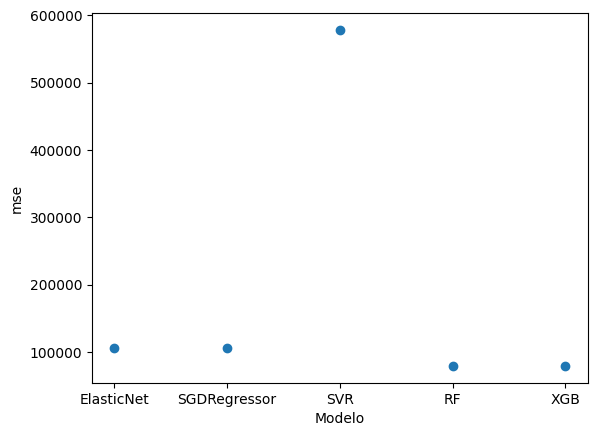

In [22]:
mse = [mse_ElasticNet, mse_SGDRegressor, mse_SVR, mse_RF, mse_XGB]
plt.scatter(['ElasticNet', 'SGDRegressor', 'SVR', 'RF', 'XGB'], mse)
plt.ylabel('mse')
plt.xlabel('Modelo');

El peor modelo sería el Support Vector Regression (SVR) y el mejor sería Boosting Gradient Descent (XGB)

# Clasificación: `y=penguins["island"]`

Queremos que nuestra variable objetivo, **y**, sea la isla de los pingüinos, y vamos a predecirlo con las variables de **X**: Bill length, bill depth, flipper length, sex y species

In [23]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
y = penguins["island"]

## Modelo 1. Modelo Logístico

In [24]:
#Librerías
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Instanciamos el modelo
model = LogisticRegression(C=0.15, max_iter=3000)

#Entrnamos en los datos
model.fit(X_train, y_train)

#Predecimos
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.82      0.84      0.83        49
       Dream       0.65      0.84      0.73        37
   Torgersen       0.50      0.07      0.12        14

    accuracy                           0.73       100
   macro avg       0.66      0.58      0.56       100
weighted avg       0.71      0.73      0.69       100



In [25]:
clasificacion #Para ver cómo ha quedado el dataframe tras las transformaciones

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


In [26]:
#Librerías
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Instanciamos el modelo (con parámetros diferentes)
model = LogisticRegression(max_iter=100)

#Entrnamos en los datos
model.fit(X_train, y_train)

#Predecimos
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.82      0.84      0.83        49
       Dream       0.70      0.84      0.77        37
   Torgersen       0.33      0.14      0.20        14

    accuracy                           0.74       100
   macro avg       0.62      0.61      0.60       100
weighted avg       0.71      0.74      0.72       100



Vemos como algunos datos cambiaron. Pequeña demostración práctica de cómo los parámetros pueden mejorar la bondad del ajuste / la precisión de nuestros modelos!

In [27]:
clasificacion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Modelo 2. K-Nearest Neighbours

In [28]:
#Librerías
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Parámetros
weights = 'distance'
p = 2
n_neighbours = 6 #mayor accuracy que con n=5

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Modelo y predicciones
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.79      0.86      0.82        49
       Dream       0.82      0.86      0.84        37
   Torgersen       0.38      0.21      0.27        14

    accuracy                           0.77       100
   macro avg       0.66      0.65      0.65       100
weighted avg       0.74      0.77      0.75       100



In [29]:
valores_de_k = list(range(1,31))
grid_de_k = dict(n_neighbors = valores_de_k)

from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(weights = weights, p = p)
grid = GridSearchCV(knn, grid_de_k,cv =10, scoring='accuracy', return_train_score=False, verbose=1)
grid_search = grid.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'n_neighbors': 1}


In [30]:
clasificacion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Modelo 3. Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Modelo
NBmodelo = GaussianNB()

NBmodelo.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Biscoe       0.79      0.86      0.82        49
       Dream       0.82      0.86      0.84        37
   Torgersen       0.38      0.21      0.27        14

    accuracy                           0.77       100
   macro avg       0.66      0.65      0.65       100
weighted avg       0.74      0.77      0.75       100



In [32]:
clasificacion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


## Modelo 4. Support Vector Machine

Versión Simple

In [33]:
#Librerías
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Obtenemos predicciones
SVM = svm.SVC()
SVM.fit(X_train, y_train)
y_preds = SVM.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

      Biscoe       1.00      0.82      0.90        49
       Dream       0.62      0.97      0.76        37
   Torgersen       0.00      0.00      0.00        14

    accuracy                           0.76       100
   macro avg       0.54      0.60      0.55       100
weighted avg       0.72      0.76      0.72       100



In [34]:
clasificacion

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,sex
0,0,-0.896042,0.780732,-1.426752,1
1,0,-0.822788,0.119584,-1.069474,0
2,0,-0.676280,0.424729,-0.426373,0
4,0,-1.335566,1.085877,-0.569284,0
5,0,-0.859415,1.747026,-0.783651,1
...,...,...,...,...,...
338,2,0.587352,-1.762145,0.931283,0
340,2,0.514098,-1.457000,1.002739,0
341,2,1.173384,-0.744994,1.502928,1
342,2,0.221082,-1.202712,0.788372,0


Version con dibujos (más dificil)

In [35]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
Y = penguins["island"]

C:\Users\Sabela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=30000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


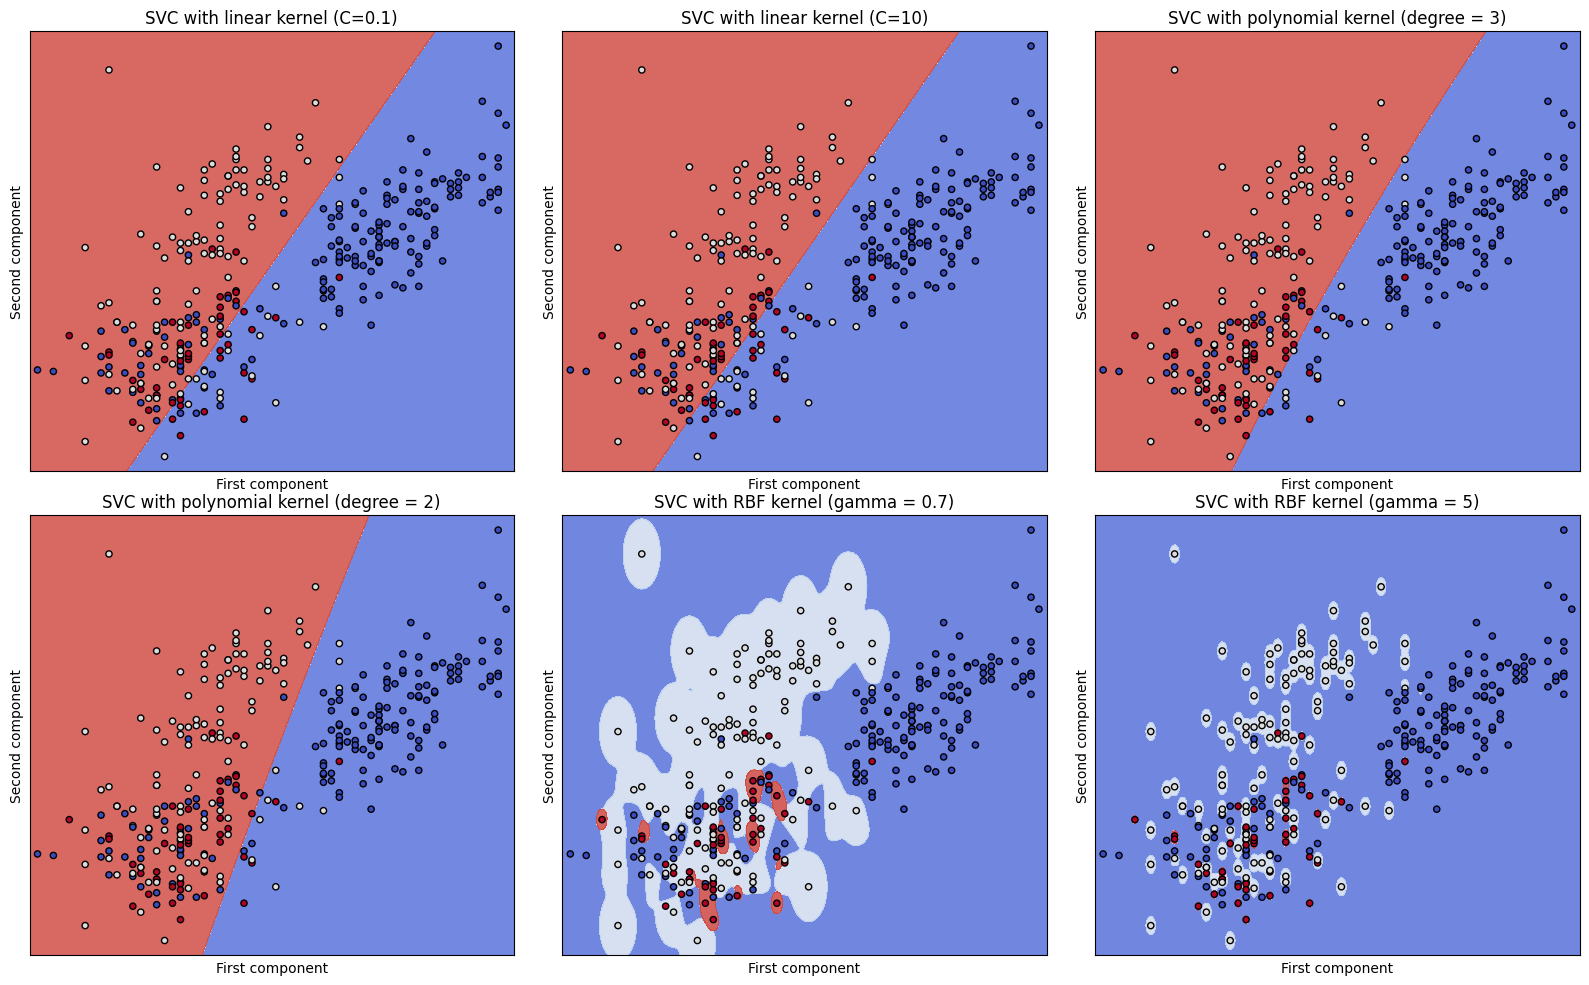

In [38]:
#Librerías
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

def make_meshgrid(x, y, h=.02):
    """Creamos una malla de puntos para graficar

    Parámetros
    ----------
    x: datos en los que basar el eje x de la malla
    y: datos en los que basar el eje y de la malla
    h: tamaño de paso en la malla, opcional

    Retorna
    -------
    xx, yy : array ndimensional
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Dibuja los límites de decisión para un clasificador.

    Parámetros
    ----------
    ax: objeto "ejes" de matplotlib
    clf: un clasificador
    xx: malla array ndimensional
    yy: malla array ndimensional
    params: diccionario de parámetros que mandar a contourf, opcional

    Retorna
    out: objeto de contorno
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

#Variable explicada
isla = Y.copy()

#Variables explicativas (tenemos que seleccionar 2 de las columnas para poder graficar)
clasificacion = X.copy()
columnas = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm','sex'] # las columnas que tenemos
clasificacion = clasificacion[columnas]
clasificacion = clasificacion[["flipper_length_mm","bill_length_mm"]] #Seleccionamos las columnas deseadas manualmente

# #Normalizamos las variables numéricas
# scaler = StandardScaler()

# for col in columnas:
#     if clasificacion[col].dtypes != "object":
#         clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

isla = encoder.fit_transform(isla)

for col in columnas:
    try:
        if clasificacion[col].dtypes == "object":
            clasificacion[col] = encoder.fit_transform(clasificacion[col])
        else:
            pass
    except:
        pass

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, isla, stratify=isla, test_size = .3, random_state=42)

# Creamos una instancia de SVM y entrenamos los datos. 
# No escalamos nuestros datos puesto que queremos graficar los supports vectors
C = 1.0  # Parámetro de regularización de SVM
models = (
        svm.SVC(kernel='linear', C=0.1),
        svm.SVC(kernel='linear', C= 10, max_iter=30000),
        svm.SVC(kernel='poly', degree = 3, C=C),
        svm.SVC(kernel='poly', degree = 2, C=C),
        svm.SVC(kernel='rbf', gamma=0.7, C=C),
        svm.SVC(kernel='rbf', gamma=5, C=C))
models = (clf.fit(clasificacion, isla) for clf in models)

# Títulos para los gráficos
titles = ('SVC with linear kernel (C=0.1)',
        'SVC with linear kernel (C=10)',
        'SVC with polynomial kernel (degree = 3)',
        'SVC with polynomial kernel (degree = 2)',
        'SVC with RBF kernel (gamma = 0.7)',
        'SVC with RBF kernel (gamma = 5)')

# Montamos una malla 2x3 para graficar
fig, sub = plt.subplots(2,3,figsize=(20,12))
plt.subplots_adjust(wspace=.1, hspace=.1)

clasificacion = np.array(clasificacion)  # Convertimos X a un array de NumPy
isla = np.array(isla)  # Convertimos Y a un array de NumPy
X0, X1 = clasificacion[:, 0], clasificacion[:,1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=isla, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('First component') # En este caso, Species
    ax.set_ylabel('Second component') # En este caso, bill_length_mm
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

## Modelo 5. Decission Tree

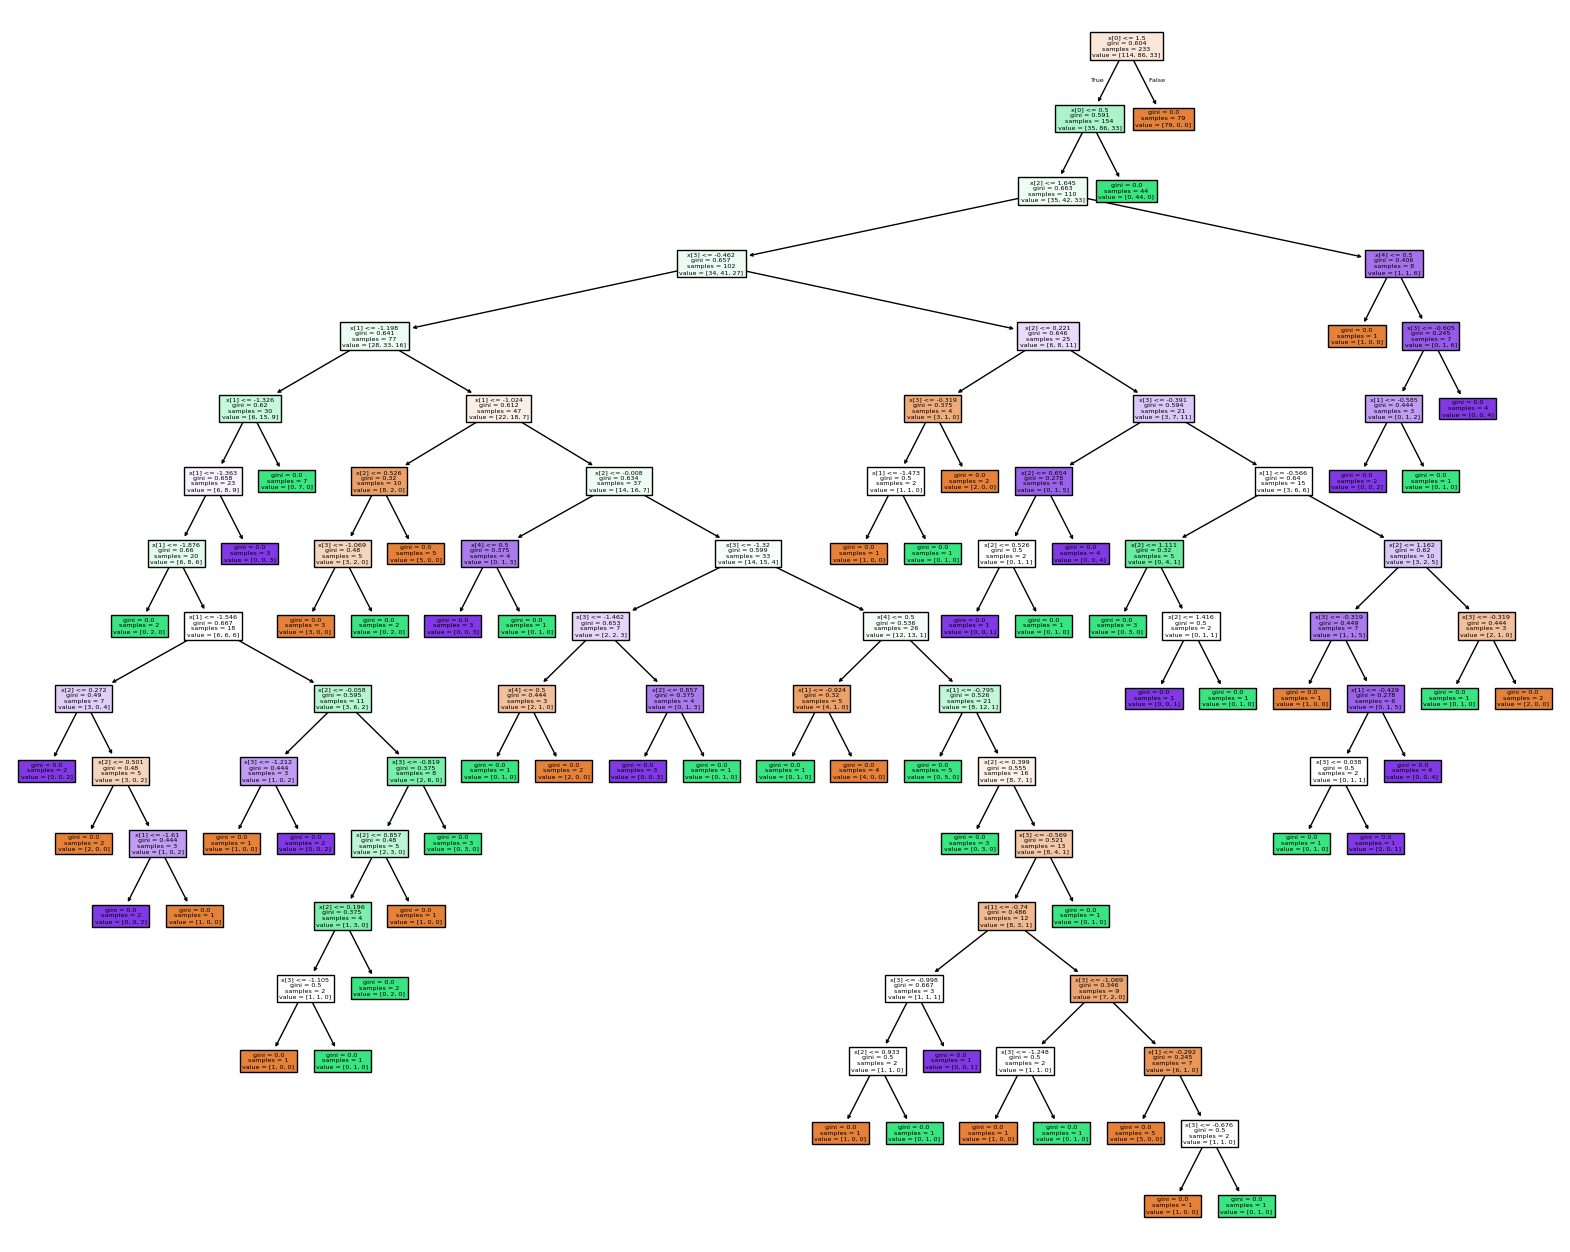

In [41]:
#Librerías
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

plt.figure(figsize = (20,16))
clf = DecisionTreeClassifier().fit(X_train, y_train)
plot_tree(clf, filled=True)
plt.show()

## Modelo 6. Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)
y_preds = RFC.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

      Biscoe       0.80      0.88      0.83        49
       Dream       0.76      0.78      0.77        37
   Torgersen       0.12      0.07      0.09        14

    accuracy                           0.73       100
   macro avg       0.56      0.58      0.57       100
weighted avg       0.69      0.73      0.71       100



Ponemos a prueba el modelo

In [43]:
isla = np.array([[0,39.2,18.6,181.2,0]])

In [44]:
RFC.predict(isla)

C:\Users\Sabela\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['Dream'], dtype=object)

In [45]:
penguins["island"].unique() #está prediciendo que es una de estas 3

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

## Extra: *Receiver Operating Characteristic*

Esto no es un modelo, se tiene que añadir al modelo que quieras y listo, pero este código dará error

In [ ]:
#Librerías
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Inicializamos los vectores de probabilidades y false_positive_rate, true_positive_rate
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred)
RF_auc = roc_auc_score(y_test, y_pred)

# Dibujamos
plt.figure(figsize=(8,5))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={auc:.2f}'.format(auc=RF_auc))
plt.legend()
plt.show()

Por ejemplo:

In [ ]:
#Librerías
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Parámetros
weights = 'distance'
p = 2
n_neighbours = 5

#Variables dependientes
clasificacion = X.copy()
columnas = ["species", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "sex"]
clasificacion = clasificacion[columnas]

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in columnas:
    if clasificacion[col].dtypes != "object":
        clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))

#Codeamos las variables no numéricas
encoder = LabelEncoder()

for col in columnas:
    if clasificacion[col].dtypes == "object":
        clasificacion[col] = encoder.fit_transform(clasificacion[col])

#Dividimos los datos en datos de entrenamiento y datos de validación
X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

#Modelo
clf = KNeighborsClassifier(n_neighbors = n_neighbours, weights = weights, p = p)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

#Inicializamos los vectores de probabilidades y false_positive_rate, true_positive_rate
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred)
RF_auc = roc_auc_score(y_test, y_pred)

# Dibujamos
plt.figure(figsize=(8,5))
plt.plot(RF_fpr, RF_tpr, marker='.', label='Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC={auc:.2f}'.format(auc=RF_auc))
plt.legend()
plt.show()

#### Atención! El roc va a seguir sin funcionar, porque y_pred solo puede tomar 2 valores, ya que el roc mide aciertos vs fallos. Sin embargo, el código está bien escrito, es simplemente un problema del conjunto de datos, que no tiene ninguna variable "binaria" ( ejs.: hombre-mujer, true-false, maduro-inmaduro, 0-1, aprobado-suspenso....)

# Aprendizaje No Supervisado

## Kmeans

In [48]:
X = penguins.drop(columns=["island", "body_mass_g"], axis=1)
y = penguins["island"]

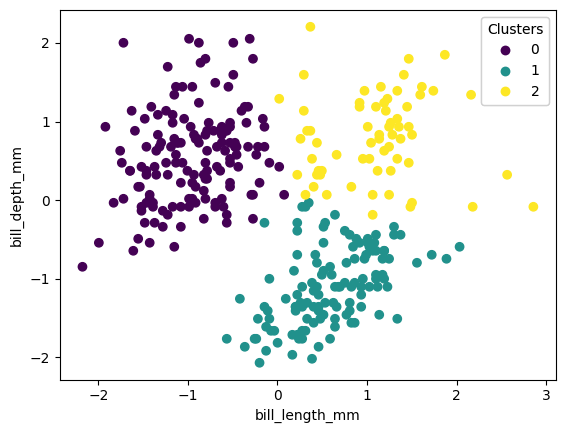

In [49]:
#Librerías
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Fijamos una semilla
np.random.seed(42)

#Variables dependientes (tenemos que seleccionar 2 de las columnas para poder graficar)
clasificacion = X.copy()
columnas = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm','sex'] # las columnas que tenemos
clasificacion = clasificacion[columnas]
clasificacion = clasificacion[["bill_length_mm","bill_depth_mm"]] #Seleccionamos las columnas deseadas manualmente

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in clasificacion.columns:
    try:
        if clasificacion[col].dtypes != "object":
            clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))
        else:
            pass
    except:
        pass

#Codeamos las variables no numéricas (si hay)
encoder = LabelEncoder()

for col in clasificacion.columns:
    try:
        if clasificacion[col].dtypes == "object":
            clasificacion[col] = encoder.fit_transform(clasificacion[col])
        else:
            pass
    except:
        pass

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

#Dividimos los datos en datos de entrenamiento y datos de validación (No hay que hacer esto en un NO supervisado)
# X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

# Instanciamos el modelo
clusters = len(np.unique(y_encoded))
km = KMeans(n_clusters=clusters, random_state=42)
km.fit(clasificacion)
y_pred = km.predict(clasificacion)

# Graficamos
clasificaciones=np.array(clasificacion)
scatter = plt.scatter(clasificaciones[:,0], clasificaciones[:,1], c=y_pred, cmap='viridis')

# Añadimos nombres a los ejes
plt.xlabel(clasificacion.columns[0])
plt.ylabel(clasificacion.columns[1])

# Leyenda personalizada
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend1)

plt.show();

Vamos a deshacer el encoding para ver a qué isla se refiere cada cluster de puntos

In [50]:
y

0      Torgersen
1      Torgersen
2      Torgersen
4      Torgersen
5      Torgersen
         ...    
338       Biscoe
340       Biscoe
341       Biscoe
342       Biscoe
343       Biscoe
Name: island, Length: 333, dtype: object

In [51]:
y_encoded

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [52]:
np.unique(y_encoded)

array([0, 1, 2])

In [53]:
y_encoder.inverse_transform(np.unique(y_pred))

array(['Biscoe', 'Dream', 'Torgersen'], dtype=object)

Este es el gráfico con los datos reales

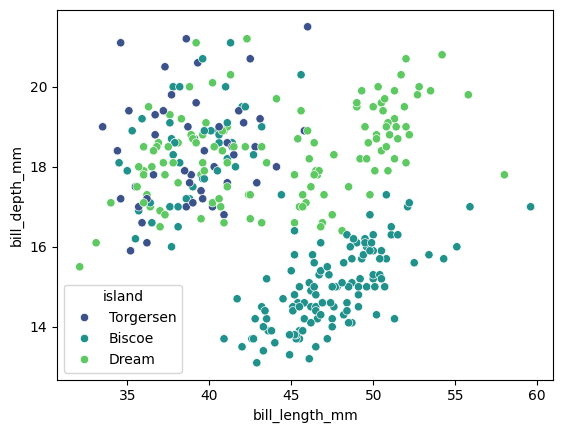

In [57]:
fig = sns.scatterplot(x = penguins["bill_length_mm"], y = penguins["bill_depth_mm"], hue = penguins["island"], palette = 'viridis')

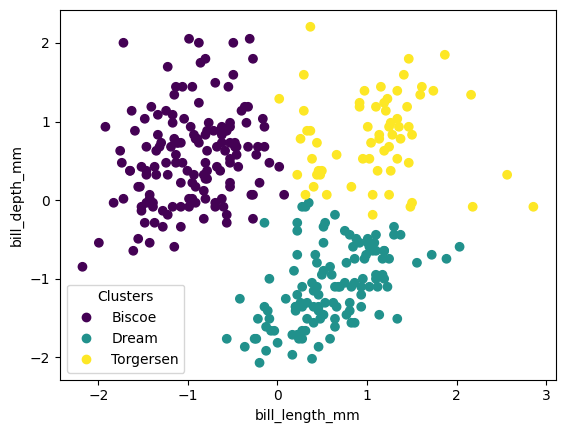

In [55]:
#Librerías
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Fijamos una semilla
np.random.seed(42)

#Variables dependientes (tenemos que seleccionar 2 de las columnas para poder graficar)
clasificacion = X.copy()
columnas = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm','sex'] # las columnas que tenemos
clasificacion = clasificacion[columnas]
clasificacion = clasificacion[["bill_length_mm","bill_depth_mm"]] #Seleccionamos las columnas deseadas manualmente

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in clasificacion.columns:
    try:
        if clasificacion[col].dtypes != "object":
            clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))
        else:
            pass
    except:
        pass

#Codeamos las variables no numéricas (si hay)
encoder = LabelEncoder()

for col in clasificacion.columns:
    try:
        if clasificacion[col].dtypes == "object":
            clasificacion[col] = encoder.fit_transform(clasificacion[col])
        else:
            pass
    except:
        pass

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

#Dividimos los datos en datos de entrenamiento y datos de validación (No hay que hacer esto en un NO supervisado)
# X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

# Instanciamos el modelo
clusters = len(np.unique(y_encoded))
km = KMeans(n_clusters=clusters, random_state=42)
km.fit(clasificacion)
y_pred = km.predict(clasificacion)

# Graficamos
clasificaciones=np.array(clasificacion)
scatter = plt.scatter(clasificaciones[:,0], clasificaciones[:,1], c=y_pred, cmap='viridis')

# Añadimos nombres a los ejes
plt.xlabel(clasificacion.columns[0])
plt.ylabel(clasificacion.columns[1])

# Leyenda personalizada
cluster_labels = y_encoder.inverse_transform(np.unique(y_pred))
handles, _ = scatter.legend_elements()
plt.legend(handles, cluster_labels, title="Clusters")

plt.show();

Como se puede ver, los clusteres los identifica más o menos bien, al menos los de la derecha, pero no están bien adjudicados los nombres, aunque eso podría ser porque los datos encodeados están desordenados. Podría solucionarse añadiendo un mapeo manual en vez de encodear las islas o añadir las etiquetas corregidas de la leyenda (aunque también podría ser que el modelo simplemente predice mal las islas)

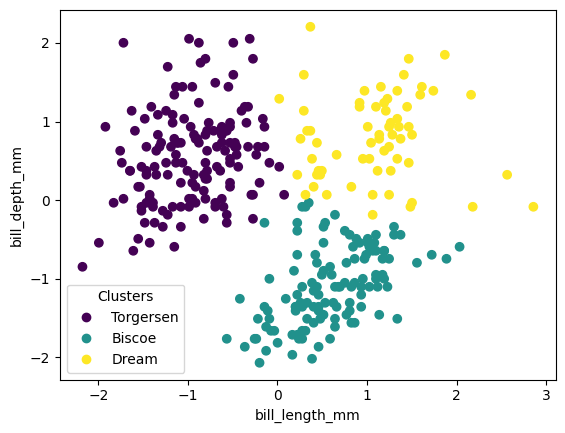

In [56]:
#Librerías
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Fijamos una semilla
np.random.seed(42)

#Variables dependientes (tenemos que seleccionar 2 de las columnas para poder graficar)
clasificacion = X.copy()
columnas = ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm','sex'] # las columnas que tenemos
clasificacion = clasificacion[columnas]
clasificacion = clasificacion[["bill_length_mm","bill_depth_mm"]] #Seleccionamos las columnas deseadas manualmente

#Normalizamos las variables numéricas
scaler = StandardScaler()

for col in clasificacion.columns:
    try:
        if clasificacion[col].dtypes != "object":
            clasificacion[col] = scaler.fit_transform(clasificacion[col].values.reshape(-1,1))
        else:
            pass
    except:
        pass

#Codeamos las variables no numéricas (si hay)
encoder = LabelEncoder()

for col in clasificacion.columns:
    try:
        if clasificacion[col].dtypes == "object":
            clasificacion[col] = encoder.fit_transform(clasificacion[col])
        else:
            pass
    except:
        pass

y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(y)

#Dividimos los datos en datos de entrenamiento y datos de validación (No hay que hacer esto en un NO supervisado)
# X_train, X_test, y_train, y_test = train_test_split(clasificacion, y, stratify=y, test_size = .3, random_state=42)

# Instanciamos el modelo
clusters = len(np.unique(y_encoded))
km = KMeans(n_clusters=clusters, random_state=42)
km.fit(clasificacion)
y_pred = km.predict(clasificacion)

# Graficamos
clasificaciones=np.array(clasificacion)
scatter = plt.scatter(clasificaciones[:,0], clasificaciones[:,1], c=y_pred, cmap='viridis')

# Añadimos nombres a los ejes
plt.xlabel(clasificacion.columns[0])
plt.ylabel(clasificacion.columns[1])

# Leyenda personalizada
cluster_labels = ['Torgersen', 'Biscoe', 'Dream']
handles, _ = scatter.legend_elements()
plt.legend(handles, cluster_labels, title="Clusters")

plt.show();